In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

root_dir = ''

if IN_COLAB:
    !pip3 install scanpy
    !pip3 install leidenalg
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/semiVAE_all/')
    ## path for model folder
    root_dir = '/content/drive/MyDrive/SpatialModelProject/semiVAE_all/'

In [2]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'w'
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context
from semiVAE import get_gsva,utils,data_loader,poe_trainer,sigvae_trainer,poe_model,get_recon,sigvae_model,plot_utils, postprocess

In [5]:
#data_folder = 'simu_data'
data_folder = 'data'

## data name
sample_id='CID444971'
#sample_id='simu_1'

## signature table
sig_file_name = 'data/bc_signatures_version_0201.csv'
#sig_file_name = 'simu_marker2.csv'

## gsva file
gsva_file_name = root_dir+'results/01_gsva/'+sample_id+'_gsva.csv'

gsva_save_path = 'results/01_gsva/'+sample_id+'_gsva.csv'

In [9]:
if sample_id.startswith('MBC'):
    adata_sample = sc.read_visium(path=os.path.join(root_dir,data_folder, sample_id),library_id =  sample_id)
    adata_sample.var_names_make_unique()
    adata_sample.obs['sample']=sample_id
else:
    adata_sample = sc.read_h5ad(os.path.join(root_dir,data_folder,sample_id, sample_id+'.h5ad'))
    adata_sample.var_names_make_unique()
    adata_sample.obs['sample']=sample_id
   

adata_sample_pre = utils.preprocess(adata_sample, n_top_genes=2000) 
adata_sample = adata_sample[:,adata_sample_pre.var_names]
adata_sample.var = adata_sample_pre.var
adata_sample.obs = adata_sample_pre.obs

Preprocessing1: delete the mt and rp
Preprocessing2: Normalize


/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing3: Logarithm
Preprocessing4: Find the variable genes


In [33]:
#sc.tl.pca(adata_sample, svd_solver='arpack')
#sc.pp.neighbors(adata_sample, n_neighbors=10, n_pcs=40)
#sc.tl.umap(adata_sample)

In [36]:
#var_file_name = 'simu_data/simu_1/'+sample_id+'_var_sig.csv'
#adata_sample.to_df().to_csv(var_file_name)

In [20]:
# load signature data [type x gene]
gene_sig = pd.read_csv(os.path.join(root_dir,sig_file_name),index_col=None)

In [21]:
gene_sig

,T_cells_c0_CD4+_CCR7,T_cells_c1_CD4+_IL7R,T_cells_c3_CD4+_Tfh_CXCL13,T_cells_c2_CD4+_T-regs_FOXP3,B_cells_Memory,B_cells_Naive,NK,Macrophage_M1,Macrophage_M2,Endothelial,...,cDC,pDC,Terminal_exhaustion,Precursor_exhaustion,CAFs_MSC_iCAF-like,CAFs_myCAF-like,PVL_Differentiated,PVL_Immature,Normal_epithelial,Plasmablasts
0,CCR7,IL7R,CXCL13,TNFRSF4,MS4A1,CD79A,GNLY,C1QB,CXCL10,ACKR1,...,CD80,IL3RA,CD3G,TCF7,APOD,COL1A1,ACTA2,CCL19,KRT14,IGKV3-15
1,LTB,ANXA1,NMB,LTB,CD79A,TCL1A,XCL1,C1QA,C1QB,FABP4,...,CD86,LILRA4,FASLG,MS4A4A,DCN,COL1A2,TAGLN,RGS5,KRT17,IGHG1
2,IL7R,CXCR4,NR3C1,IL32,CD83,MS4A1,XCL2,C1QC,C1QC,PLVAP,...,CCR7,CD123,ID2,TNFSF8,PTGDS,COL3A1,MYL9,IGFBP7,LTF,IGKV1-5
3,SARAF,KLRB1,DUSP4,BATF,CD37,CD37,AREG,CCL3,CXCL9,RAMP2,...,CD1A,TCF4,LAG3,CXCL10,CFD,LUM,TPM2,NDUFA4L2,KRT15,IGKV3-20
4,SELL,TNFAIP3,TNFRSF18,FOXP3,BANK1,CD74,KLRD1,CCL3L3,C1QA,VWF,...,CD1C,IRF7,RGS1,EEF1B2,LUM,SFRP2,NDUFA4L2,CCL2,PTN,IGKV3-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# image preparation
adata_image, map_info = utils.preprocess_img(root_dir+data_folder,sample_id,adata_sample.obs.index,hchannal=False)

/Users/siyuhe/03_Spatial_project/semiVAE/utils.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_info.loc[:,'imagerow'] = tissue_position_list.iloc[:,3] *tissue_hires_scalef
/Users/siyuhe/03_Spatial_project/semiVAE/utils.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_info.loc[:,'imagecol'] = tissue_position_list.iloc[:,4] *tissue_hires_scalef


In [23]:
# run gsva , gsva is based on the signature gene
run_gsva = False

if run_gsva:
    gsva_score = get_gsva.get_gsva(sample_id, var_file_name, sig_file_name)
    gsva_score.to_csv(gsva_save_path)
else:
    gsva_score = pd.read_csv(gsva_file_name,index_col=0)

In [24]:
#member = pd.read_csv('simu_data/simu_1/members.st_synth.csv',index_col=0)
#proportions = pd.read_csv('simu_data/simu_1/proportions.st_synth.csv',index_col=0)

In [25]:
# prepare dataset for training
variable_gene, sig_gname_filtered, sig_variable_gene_inter = utils.gene_for_train(adata_sample, gene_sig)
adata_sample_filter = adata_sample[:,sig_variable_gene_inter]

the number of original variable genes in the dataset (2000,)
the number of siganture genes in the dataset (691,)
after filter out some genes in the signature not in the var_names ... (652,)
after filter out some genes not highly expressed in the signature ... (646,)
combine the varibale and siganture, the total unique gene number is ... 2492


In [26]:
gene_sig

,T_cells_c0_CD4+_CCR7,T_cells_c1_CD4+_IL7R,T_cells_c3_CD4+_Tfh_CXCL13,T_cells_c2_CD4+_T-regs_FOXP3,B_cells_Memory,B_cells_Naive,NK,Macrophage_M1,Macrophage_M2,Endothelial,...,cDC,pDC,Terminal_exhaustion,Precursor_exhaustion,CAFs_MSC_iCAF-like,CAFs_myCAF-like,PVL_Differentiated,PVL_Immature,Normal_epithelial,Plasmablasts
0,CCR7,IL7R,CXCL13,TNFRSF4,MS4A1,CD79A,GNLY,C1QB,CXCL10,ACKR1,...,CD80,IL3RA,CD3G,TCF7,APOD,COL1A1,ACTA2,CCL19,KRT14,IGKV3-15
1,LTB,ANXA1,NMB,LTB,CD79A,TCL1A,XCL1,C1QA,C1QB,FABP4,...,CD86,LILRA4,FASLG,MS4A4A,DCN,COL1A2,TAGLN,RGS5,KRT17,IGHG1
2,IL7R,CXCR4,NR3C1,IL32,CD83,MS4A1,XCL2,C1QC,C1QC,PLVAP,...,CCR7,CD123,ID2,TNFSF8,PTGDS,COL3A1,MYL9,IGFBP7,LTF,IGKV1-5
3,SARAF,KLRB1,DUSP4,BATF,CD37,CD37,AREG,CCL3,CXCL9,RAMP2,...,CD1A,TCF4,LAG3,CXCL10,CFD,LUM,TPM2,NDUFA4L2,KRT15,IGKV3-20
4,SELL,TNFAIP3,TNFRSF18,FOXP3,BANK1,CD74,KLRD1,CCL3L3,C1QA,VWF,...,CD1C,IRF7,RGS1,EEF1B2,LUM,SFRP2,NDUFA4L2,CCL2,PTN,IGKV3-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
gene_sig_exp_m = pd.DataFrame()
for i in range(gene_sig.shape[1]):
    gene_sig_exp_m[gene_sig.columns[i]]=adata_sample.to_df().loc[:,np.intersect1d(adata_sample.var_names,np.unique(gene_sig.iloc[:,i].astype(str)))].mean(axis=1)

In [53]:
gene_sig_exp_m

,T_cells_c0_CD4+_CCR7,T_cells_c1_CD4+_IL7R,T_cells_c3_CD4+_Tfh_CXCL13,T_cells_c2_CD4+_T-regs_FOXP3,B_cells_Memory,B_cells_Naive,NK,Macrophage_M1,Macrophage_M2,Endothelial,...,cDC,pDC,Terminal_exhaustion,Precursor_exhaustion,CAFs_MSC_iCAF-like,CAFs_myCAF-like,PVL_Differentiated,PVL_Immature,Normal_epithelial,Plasmablasts
AACATTGGTCAGCCGT-1,0.057143,0.055556,0.06250,0.054054,0.205882,0.152174,0.030303,0.258065,0.258621,0.071429,...,0.000000,0.000,0.033333,0.095238,0.225806,0.258065,0.166667,0.166667,0.394737,0.142857
CATCGAATGGATCTCT-1,0.342857,0.027778,0.09375,0.054054,0.264706,0.239130,0.060606,0.451613,0.517241,0.267857,...,0.083333,0.125,0.133333,0.380952,0.322581,0.354839,1.333333,1.066667,1.552632,0.285714
CGGGTTGTAGCTTTGG-1,2.171429,0.944444,0.53125,0.675676,1.264706,1.434783,0.333333,2.016129,1.741379,1.232143,...,0.166667,0.125,0.733333,2.095238,1.903226,1.258065,5.166667,3.466667,10.263158,0.514286
CCTAAGTGTCTAACCG-1,0.114286,0.055556,0.00000,0.000000,0.058824,0.065217,0.030303,0.145161,0.155172,0.142857,...,0.000000,0.000,0.033333,0.000000,0.322581,0.258065,0.300000,0.233333,0.947368,0.000000
TCTGTGACTGACCGTT-1,1.114286,0.500000,0.21875,0.135135,0.617647,0.586957,0.212121,1.096774,1.189655,0.714286,...,0.000000,0.375,0.100000,1.238095,1.451613,1.000000,3.133333,2.466667,7.631579,0.114286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGCAGTGGTAGGGAAC-1,0.542857,0.333333,0.21875,0.216216,1.205882,0.826087,0.121212,1.290323,1.413793,0.375000,...,0.083333,0.125,0.266667,0.285714,1.870968,4.193548,1.300000,2.033333,2.026316,0.714286
AGCGAGACGTGAAGGC-1,1.914286,0.833333,0.46875,0.567568,1.764706,1.456522,0.242424,2.177419,2.327586,0.821429,...,0.083333,0.000,0.166667,1.380952,2.193548,5.580645,1.833333,2.700000,3.842105,1.428571
CAGTGTTAATCTCTCA-1,0.257143,0.138889,0.12500,0.081081,0.441176,0.260870,0.030303,0.435484,0.431034,0.250000,...,0.000000,0.125,0.166667,0.285714,0.580645,0.838710,0.766667,0.766667,1.236842,0.400000
GATCGCTGTGGTGCGT-1,0.714286,0.361111,0.21875,0.324324,1.088235,0.804348,0.121212,1.161290,1.086207,1.553571,...,0.000000,0.000,0.200000,0.666667,1.580645,1.967742,1.666667,2.033333,1.236842,1.685714


In [97]:
import torch.nn as nn
from torch.distributions import Normal, LogNormal,Dirichlet, kl_divergence as kl
import torch

class semiGe_VAE(nn.Module):
    """ simple model design ***
    p(x|z)=f(z)
    p(z|x)~N(0,1)
    q(z|x)~g(x)
    """
    
    def __init__(self,
                 adata,
                 gene_sig
    ) -> None:
        """
                 
        """
        super(semiGe_VAE, self).__init__()
        self.c_in = adata.shape[1] # c_in : Num. input features (# input genes)
        self.c_bn = 20 # c_bn : latent number, numbers of bottle neck
        self.c_hidden = 128
        self.c_kn = gene_sig.shape[1]
        
        self.c_enc = nn.Sequential(
                                nn.Linear(self.c_in, self.c_hidden, bias=True),
                                nn.BatchNorm1d(self.c_hidden, momentum=0.01,eps=0.001),
                                nn.ReLU(),
                                nn.Linear(self.c_hidden, self.c_kn, bias=True),
                                nn.BatchNorm1d(self.c_kn, momentum=0.01,eps=0.001),
                                nn.ReLU(),
                                nn.Softmax()
        )
        
        # neural network f1 to get the z, p(z|x), f1(x,\phi_1)=[z_m,torch.exp(z_logv)]
        self.z_enc = nn.Sequential(
                                nn.Linear(self.c_kn, self.c_hidden, bias=True),
                                nn.BatchNorm1d(self.c_hidden, momentum=0.01,eps=0.001),
                                nn.ReLU(),
        )
        self.z_enc_m = nn.Linear(self.c_hidden, self.c_bn)
        self.z_enc_logv = nn.Linear(self.c_hidden, self.c_bn)
        
        # gene dispersion
        self.px_r = torch.nn.Parameter(torch.randn(self.c_in))

        # neural network g to get the x_m and x_v, p(x|z), g(z,\phi_3)=[x_m,x_v]
        self.px_hidden_decoder = nn.Sequential(
                                nn.Linear(self.c_bn, self.c_hidden, bias=True),
                                nn.ReLU(),         
        )
        self.px_scale_decoder = nn.Sequential(
                              nn.Linear(self.c_hidden,self.c_in),
                              #nn.ReLU(),
                              nn.Softplus()
        )
        self.px_r_decoder = nn.Sequential(
                              nn.Linear(self.c_hidden,self.c_in),
                              nn.ReLU(),
        )
         
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    def inference(self,
                  x
                 ):
        #print('x',x)
        x=torch.log(1+x)
        qc_p = self.c_enc(x)
        
        hidden = self.z_enc(qc_p)
        qz_m = self.z_enc_m(hidden)
        qz_logv = self.z_enc_logv(hidden)
        qz = self.reparameterize(qz_m, qz_logv)

        return dict(
                    qc_p = qc_p,
                    qz_m=qz_m,
                    qz_logv = qz_logv,
                    qz=qz,
                   )
    
    def generative(self,
                   inference_outputs,
                   library
                  ):
        
        qz = inference_outputs['qz']
        hidden = self.px_hidden_decoder(qz)
        px_scale = self.px_scale_decoder(hidden)
        px_rate = torch.exp(library) * px_scale 
        px_r = self.px_r
        

        return dict(
                    px_rate=px_rate,
                    px_r=px_r
                   )
    
    
    def get_loss(self,
            generative_outputs,
            inference_outputs,
            x, 
            gene_sig_m
                 
        ):
        
        qc_p = inference_outputs["qc_p"]
        qz_m = inference_outputs["qz_m"]
        qz_logv = inference_outputs["qz_logv"]
        qz = inference_outputs["qz"]
        
        px_rate = generative_outputs["px_rate"]
        px_r = generative_outputs["px_r"]
        
        re_loss = torch.nn.MSELoss(
            reduction='sum'
        )

        #reconst_loss  = re_loss(px.view(1,-1), x.view(1,-1))
        #KLD      = - 0.5 * torch.sum(1+ qz_logv - qz_m.pow(2) - qz_logv.exp())
        
        mean = torch.zeros_like(qz_m)
        scale = torch.ones_like(qz_logv)
        
        #print('qz_m=',qz_m)
        #print('torch.sqrt(torch.exp(qz_logv))=',torch.sqrt(torch.exp(qz_logv)))
        
        #print(kl(Normal(qz_m, torch.sqrt(torch.exp(qz_logv))), Normal(mean, scale)).shape)
        kl_divergence_z = kl(Normal(qz_m, torch.sqrt(torch.exp(qz_logv))), Normal(mean, scale)).sum(
            dim=1
        )
        #print(kl(Dirichlet(qc_p), Dirichlet(torch.ones_like(qc_p)/qc_p.shape[1])).shape)
        #kl_divergence_c = kl(Dirichlet(qc_p), Dirichlet(torch.ones_like(qc_p)/qc_p.shape[1]))
        #print(gene_sig_m.shape)
        #print(gene_sig_m.sum(axis=1).shape)
        kl_divergence_c = kl(Dirichlet(qc_p), Dirichlet(gene_sig_m))
        
        #print('px_rate=',px_rate.mean())
        #print('px_rate=',px_rate.mean())
        reconst_loss = -NegBinom(px_rate, torch.exp(px_r)).log_prob(x).sum(-1)
        
        loss = torch.mean(reconst_loss + kl_divergence_z+kl_divergence_c)
        
        #print('reconst_loss=',reconst_loss.mean())
        #print('kl_divergence_z=',kl_divergence_z.mean())

        return (loss,
                reconst_loss,
                kl_divergence_z,
                kl_divergence_c
               )

    
    
from tqdm import tqdm
from torch.distributions import Normal, kl_divergence as kl
def train(
            model,
            dataloader,
            dataset,
            device,
            optimizer,
        ):
    model.train()
    
    running_loss = 0.0
    counter = 0
    
    for i, (x,gsva, gene_sig_m) in enumerate(dataloader):
        
        #library  = x.sum(axis=0)
        library = torch.log(x.sum(1)).unsqueeze(1)
        library = library.to(device)
        
        counter +=1
        x = x.float()
        x = x.to(device)
        
        gsva= torch.sigmoid(gsva)
        gsva= gsva/gsva.sum(dim=1,keepdim=True)
        
        #gene_sig_m= torch.sigmoid(gene_sig_m)
        gene_sig_m = gene_sig_m+1e-5
        gene_sig_m= gene_sig_m/gene_sig_m.sum(dim=1,keepdim=True)
        
        
        

        inference_outputs =  model.inference(x)
        generative_outputs = model.generative(inference_outputs,library)
        

        
        (loss,
         reconst_loss,
         KLD,
         kl_divergence_c
        ) = model.get_loss(generative_outputs,
                        inference_outputs,                                           
                        x, 
                        gene_sig_m
                       )
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss



# Reference:
# https://github.com/YosefLab/scvi-tools/blob/master/scvi/distributions/_negative_binomial.py
from torch.distributions import kl_divergence, Distribution
from torch.distributions import Gamma,Poisson
class NegBinom(Distribution):
    """
    Gamma-Poisson mixture approximation of Negative Binomial(mean, dispersion)

    lambda ~ Gamma(mu, theta)
    x ~ Poisson(lambda)
    """

    def __init__(self, mu, theta, eps=1e-5):
        """
        Parameters
        ----------
        mu : torch.Tensor
            mean of NegBinom. distribution
            shape - [# genes,]

        theta : torch.Tensor
            dispersion of NegBinom. distribution
            shape - [# genes,]
        """
        super(NegBinom, self).__init__()
        assert (mu > 0).sum() and (theta > 0).sum(), \
            "Negative mean / dispersion of Negative detected"

        self.mu = mu
        self.theta = theta
        self.eps = eps

    def sample(self):
        #print('self.theta=',self.theta)
        #print('self.mu=',self.mu)
        #assert (self.theta +self.eps> 0).sum() and (self.mu +self.eps> 0)
        lambdas = Gamma(
            concentration=self.theta,
            rate=(self.theta+self.eps) / (self.mu+self.eps),
        ).rsample()

        x = Poisson(lambdas).sample()

        return x

    def log_prob(self, x):
        """log-likelihood"""
        ll = torch.lgamma(x + self.theta) - \
             torch.lgamma(x + 1) - \
             torch.lgamma(self.theta) + \
             self.theta * (torch.log(self.theta + self.eps) - torch.log(self.theta + self.mu + self.eps)) + \
             x * (torch.log(self.mu + self.eps) - torch.log(self.theta + self.mu + self.eps))

        return ll

In [98]:
#from generative_1layer_NB import semiGe_VAE, train
model = semiGe_VAE(
            adata = adata_sample_filter,
            gene_sig = gene_sig,
            #gsva_score_discretized = gsva_score_discretized
          )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#lr=0.001
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
trainset = utils.VisiumDataset(adata=adata_sample_filter, gsva_score=gsva_score, gene_sig_exp_m=gene_sig_exp_m)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
epochs= 100
train_loss = []
for epoch in range(epochs):
    #print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, trainloader, trainset, device, optimizer)
    train_loss.append(train_epoch_loss)
    torch.cuda.empty_cache()
    if (epoch+1) % 1 == 0:
            print ("Epoch[{}/{}], train_loss: {:.4f}" 
                   .format(epoch+1, epochs, train_epoch_loss))
    #print(f"Train Loss: {train_epoch_loss:.4f}")
print('finish lower training rate')

Epoch[1/100], train_loss: 16894.5307
Epoch[2/100], train_loss: 3336.8207
Epoch[3/100], train_loss: 2359.3459
Epoch[4/100], train_loss: 1958.5983
Epoch[5/100], train_loss: 1860.2866
Epoch[6/100], train_loss: 1772.6508
Epoch[7/100], train_loss: 1719.8823
Epoch[8/100], train_loss: 1680.5007
Epoch[9/100], train_loss: 1658.7860
Epoch[10/100], train_loss: 1638.6753
Epoch[11/100], train_loss: 1612.6195
Epoch[12/100], train_loss: 1601.3267
Epoch[13/100], train_loss: 1598.1765
Epoch[14/100], train_loss: 1564.9459
Epoch[15/100], train_loss: 1561.7610
Epoch[16/100], train_loss: 1556.1493
Epoch[17/100], train_loss: 1536.7635
Epoch[18/100], train_loss: 1535.8207
Epoch[19/100], train_loss: 1531.2861
Epoch[20/100], train_loss: 1520.8575
Epoch[21/100], train_loss: 1522.3872
Epoch[22/100], train_loss: 1511.8941
Epoch[23/100], train_loss: 1499.1999
Epoch[24/100], train_loss: 1493.9329
Epoch[25/100], train_loss: 1490.1338
Epoch[26/100], train_loss: 1486.0119
Epoch[27/100], train_loss: 1494.0862
Epoch[28/

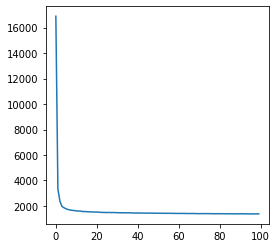

In [99]:
plt.plot(train_loss)

In [112]:
model.eval()

x_valid = torch.Tensor(np.array(adata_sample_filter.to_df()))
x_valid = x_valid.to(device)

library = torch.log(x_valid.sum(1)).unsqueeze(1)
#library  = x_valid.sum(axis=1)
#library = library.to(device)


inference_outputs =  model.inference(x_valid)
generative_outputs = model.generative(inference_outputs,library)

qz_m = inference_outputs["qz_m"].detach().numpy()
qc_p = inference_outputs["qc_p"].detach().numpy()
qz_logv = inference_outputs["qz_logv"].detach().numpy()
qz = inference_outputs["qz"].detach().numpy()
px_r = generative_outputs["px_r"].detach().numpy()
px_rate = generative_outputs["px_rate"].detach().numpy()
px = NegBinom(generative_outputs["px_rate"], torch.exp(generative_outputs["px_r"])).sample()

qc_p_df = pd.DataFrame(qc_p,columns=gene_sig_exp_m.columns,index = gene_sig_exp_m.index)

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.NegBinom'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [101]:
import umap
fit = umap.UMAP(
        #n_neighbors=20,
        #min_dist=0.01,
        #n_components=2,
        
               )
%time u = fit.fit_transform(qz)

CPU times: user 10.2 s, sys: 526 ms, total: 10.7 s
Wall time: 2.99 s


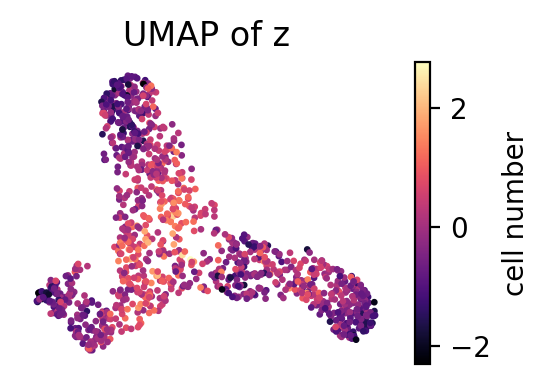

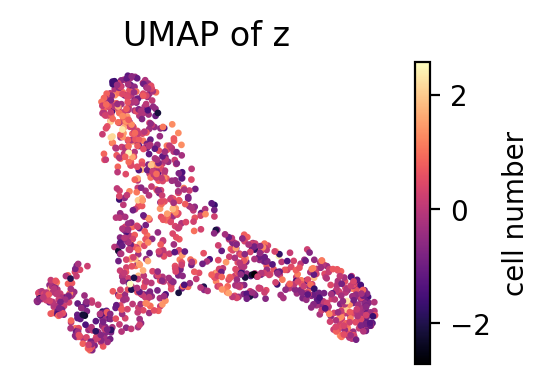

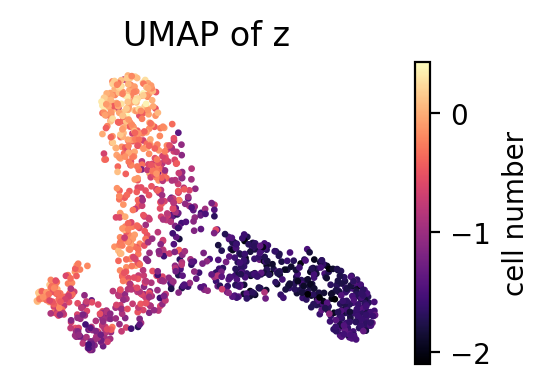

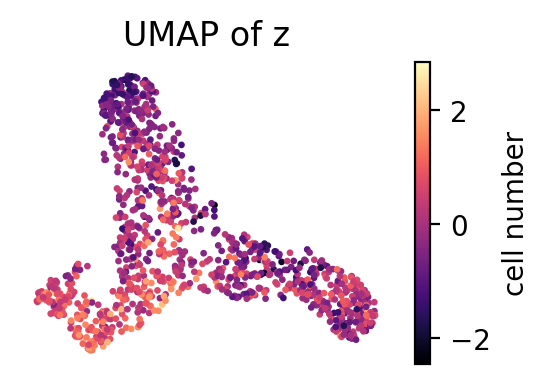

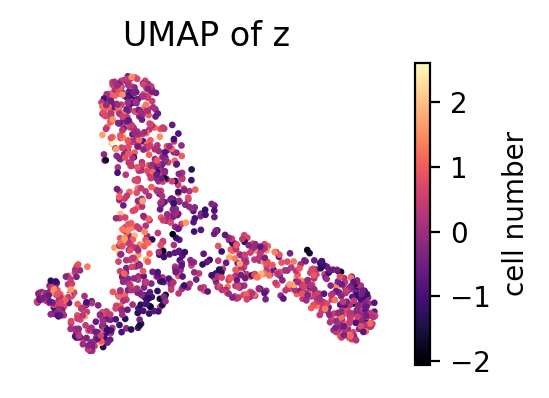

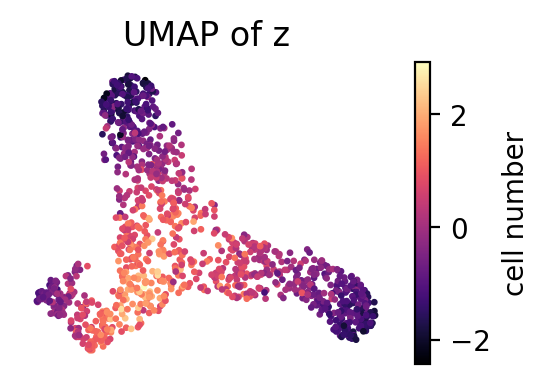

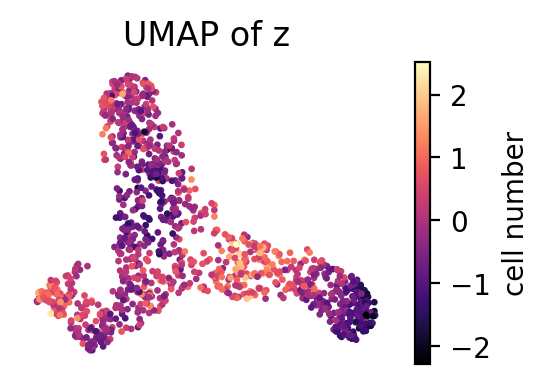

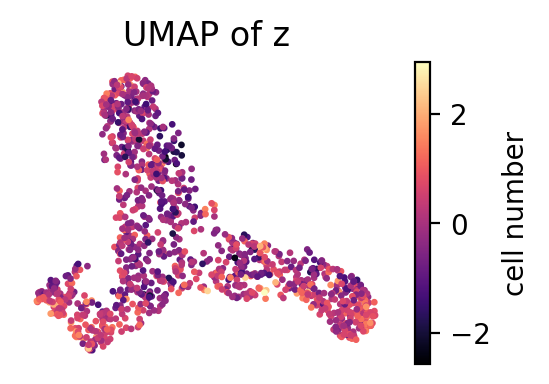

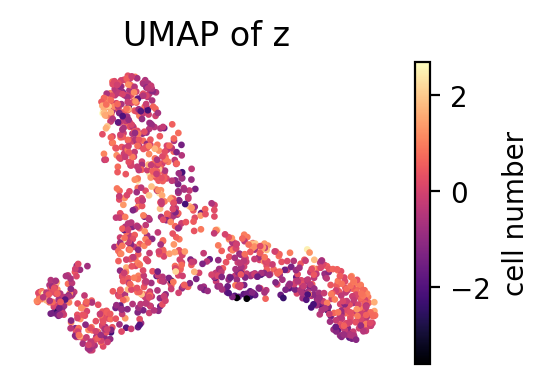

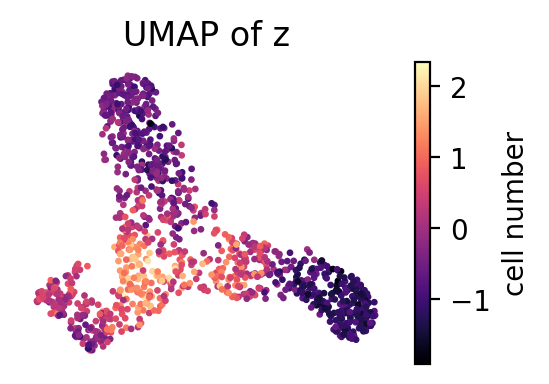

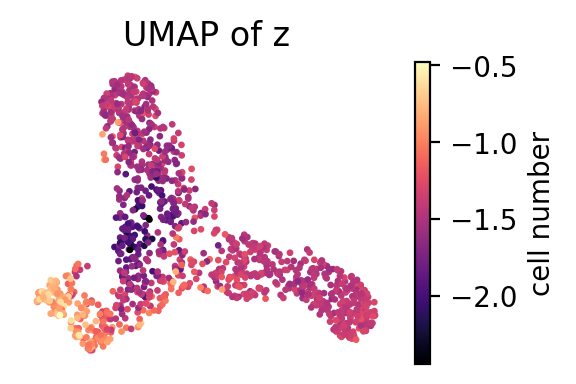

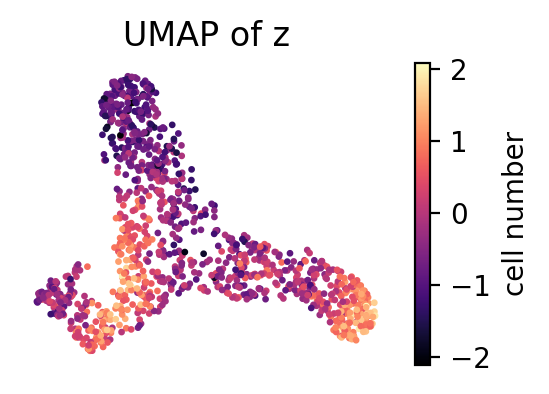

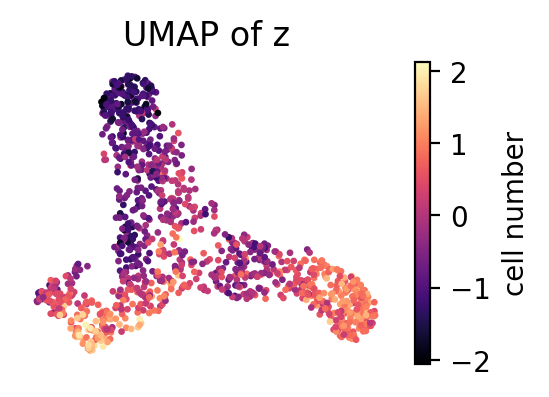

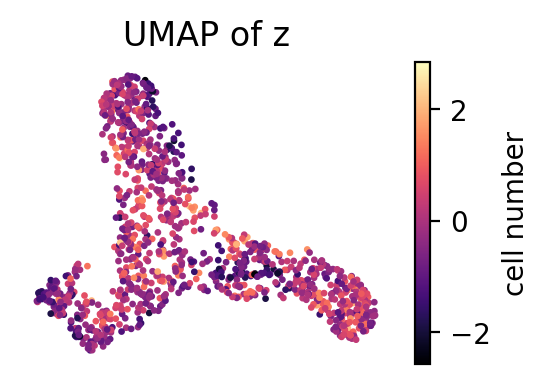

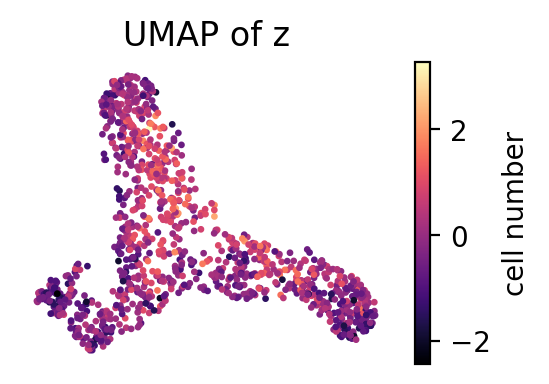

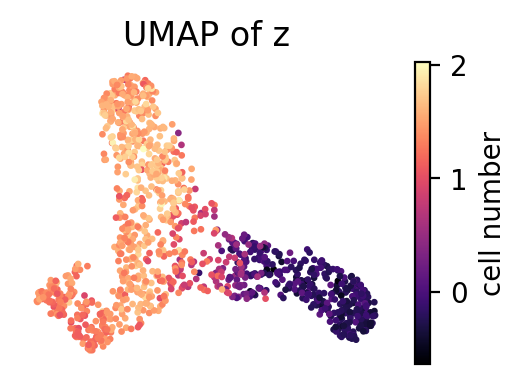

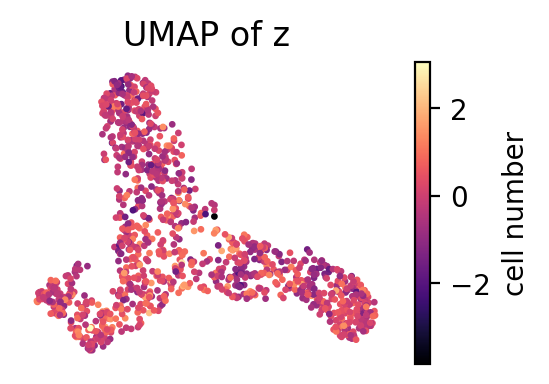

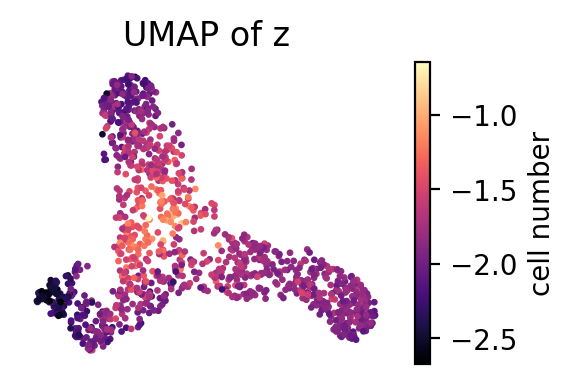

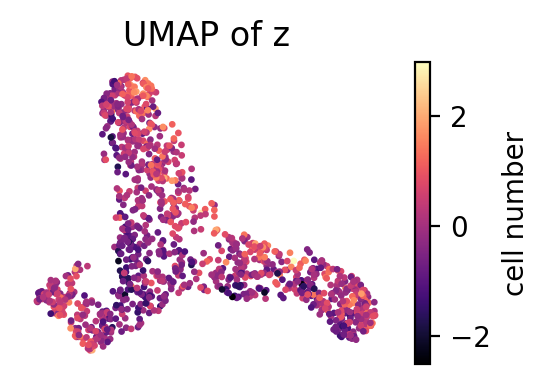

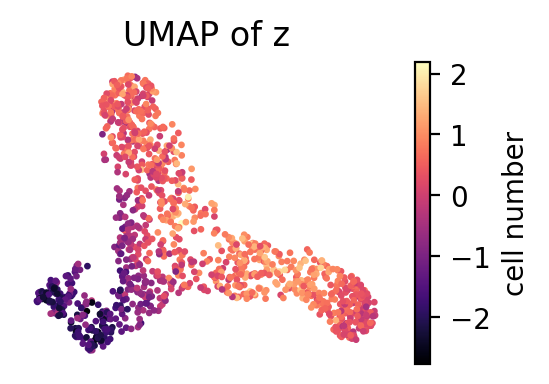

In [102]:
for i in range(qz.shape[1]):
    plt.figure(dpi=200,figsize=(3,2))
    plt.scatter(u[:,0],u[:,1],s=2,c=qz[:,i],cmap='magma')
    plt.colorbar(label='cell number')
    plt.title('UMAP of z')
    plt.axis('off')

In [103]:
gene_sig_exp_m

,T_cells_c0_CD4+_CCR7,T_cells_c1_CD4+_IL7R,T_cells_c3_CD4+_Tfh_CXCL13,T_cells_c2_CD4+_T-regs_FOXP3,B_cells_Memory,B_cells_Naive,NK,Macrophage_M1,Macrophage_M2,Endothelial,...,cDC,pDC,Terminal_exhaustion,Precursor_exhaustion,CAFs_MSC_iCAF-like,CAFs_myCAF-like,PVL_Differentiated,PVL_Immature,Normal_epithelial,Plasmablasts
AACATTGGTCAGCCGT-1,0.057143,0.055556,0.06250,0.054054,0.205882,0.152174,0.030303,0.258065,0.258621,0.071429,...,0.000000,0.000,0.033333,0.095238,0.225806,0.258065,0.166667,0.166667,0.394737,0.142857
CATCGAATGGATCTCT-1,0.342857,0.027778,0.09375,0.054054,0.264706,0.239130,0.060606,0.451613,0.517241,0.267857,...,0.083333,0.125,0.133333,0.380952,0.322581,0.354839,1.333333,1.066667,1.552632,0.285714
CGGGTTGTAGCTTTGG-1,2.171429,0.944444,0.53125,0.675676,1.264706,1.434783,0.333333,2.016129,1.741379,1.232143,...,0.166667,0.125,0.733333,2.095238,1.903226,1.258065,5.166667,3.466667,10.263158,0.514286
CCTAAGTGTCTAACCG-1,0.114286,0.055556,0.00000,0.000000,0.058824,0.065217,0.030303,0.145161,0.155172,0.142857,...,0.000000,0.000,0.033333,0.000000,0.322581,0.258065,0.300000,0.233333,0.947368,0.000000
TCTGTGACTGACCGTT-1,1.114286,0.500000,0.21875,0.135135,0.617647,0.586957,0.212121,1.096774,1.189655,0.714286,...,0.000000,0.375,0.100000,1.238095,1.451613,1.000000,3.133333,2.466667,7.631579,0.114286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGCAGTGGTAGGGAAC-1,0.542857,0.333333,0.21875,0.216216,1.205882,0.826087,0.121212,1.290323,1.413793,0.375000,...,0.083333,0.125,0.266667,0.285714,1.870968,4.193548,1.300000,2.033333,2.026316,0.714286
AGCGAGACGTGAAGGC-1,1.914286,0.833333,0.46875,0.567568,1.764706,1.456522,0.242424,2.177419,2.327586,0.821429,...,0.083333,0.000,0.166667,1.380952,2.193548,5.580645,1.833333,2.700000,3.842105,1.428571
CAGTGTTAATCTCTCA-1,0.257143,0.138889,0.12500,0.081081,0.441176,0.260870,0.030303,0.435484,0.431034,0.250000,...,0.000000,0.125,0.166667,0.285714,0.580645,0.838710,0.766667,0.766667,1.236842,0.400000
GATCGCTGTGGTGCGT-1,0.714286,0.361111,0.21875,0.324324,1.088235,0.804348,0.121212,1.161290,1.086207,1.553571,...,0.000000,0.000,0.200000,0.666667,1.580645,1.967742,1.666667,2.033333,1.236842,1.685714


(-2.6866740584373474, 9.190496623516083, 2.49512859582901, 10.209305083751678)

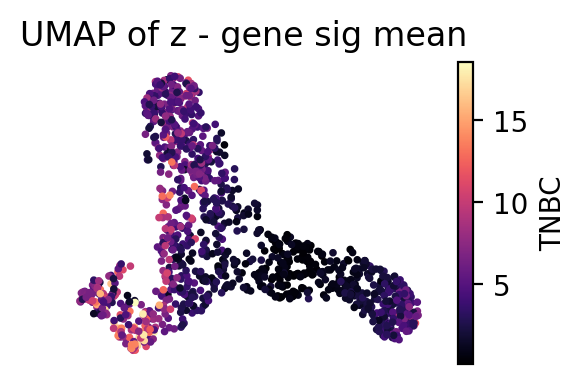

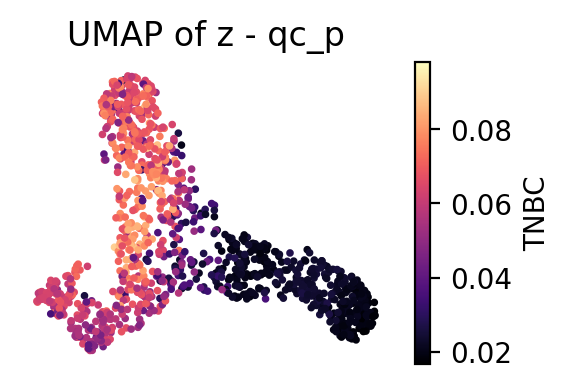

In [139]:
idx=12
plt.figure(dpi=200,figsize=(3,2))
plt.scatter(u[:,0],u[:,1],s=3,c=gene_sig_exp_m.iloc[:,idx],cmap='magma')
plt.colorbar(label=gene_sig_exp_m.columns[idx])
plt.title('UMAP of z - gene sig mean ')
plt.axis('off')

plt.figure(dpi=200,figsize=(3,2))
plt.scatter(u[:,0],u[:,1],s=3,c=qc_p[:,idx],cmap='magma')
plt.colorbar(label=gene_sig_exp_m.columns[idx])
plt.title('UMAP of z - qc_p')
plt.axis('off')

In [105]:
from scipy.stats import gaussian_kde
def display_reconst(df_true,
                    df_pred,
                    density=False,
                    marker_genes=None,
                    sample_rate=0.1,
                    size=(4, 4),
                    spot_size=1,
                    title=None,
                    x_label='',
                    y_label='',
                    ):
    """
    Scatter plot - raw gexp vs. reconstructed gexp
    """
    assert 0 < sample_rate <= 1, \
        "Invalid downsampling rate for reconstruct scatter plot: {}".format(sample_rate)

    if marker_genes is not None:
        marker_genes = set(marker_genes)

    df_true_sample = df_true.sample(frac=sample_rate, random_state=0)
    df_pred_sample = df_pred.loc[df_true_sample.index]

    plt.rcParams["figure.figsize"] = size
    plt.figure(dpi=300)
    ax = plt.gca()

    xx = df_true_sample.T.to_numpy().flatten()
    yy = df_pred_sample.T.to_numpy().flatten()

    if density:
        for gene in df_true_sample.columns:
            try:
                gene_true = df_true_sample[gene].values
                gene_pred = df_pred_sample[gene].values
                gexp_stacked = np.vstack([df_true_sample[gene].values, df_pred_sample[gene].values])

                z = gaussian_kde(gexp_stacked)(gexp_stacked)
                ax.scatter(gene_true, gene_pred, c=z, s=spot_size, alpha=0.5)
            except np.linalg.LinAlgError as e:
                pass

    elif marker_genes is not None:
        color_dict = {True: 'red', False: 'green'}
        gene_colors = np.vectorize(
            lambda x: color_dict[x in marker_genes]
        )(df_true_sample.columns)
        colors = np.repeat(gene_colors, df_true_sample.shape[0])

        ax.scatter(xx, yy, c=colors, s=spot_size, alpha=0.5)

    else:
        ax.scatter(xx, yy, s=spot_size, alpha=0.5)

    min_val = min(xx.min(), yy.min())
    max_val = max(xx.max(), yy.max())
    #ax.set_xlim(min_val, 400)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    #ax.set_ylim(min_val, 400)

    plt.suptitle(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.show()

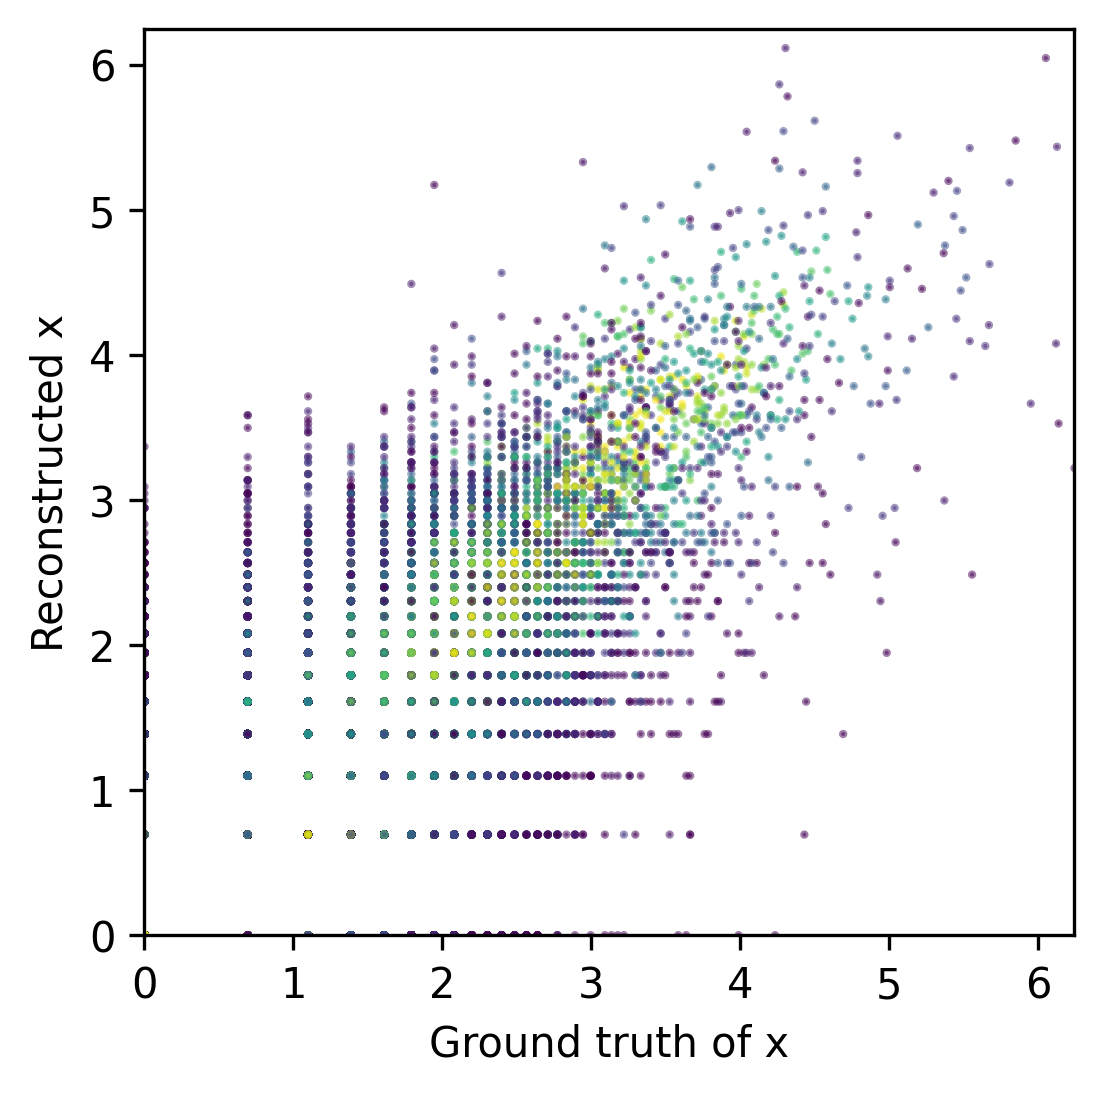

In [106]:
display_reconst(pd.DataFrame(np.log(x_valid+1)),
                pd.DataFrame(np.log(px+1)),
                density=True,
                x_label='Ground truth of x',
                y_label='Reconstructed x'
               )

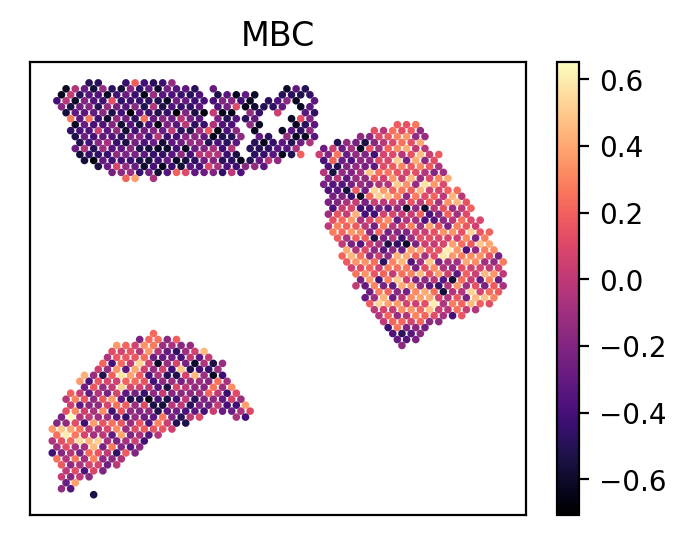

In [107]:
idx=11
plot_utils.pl_spatial_gsva(adata_sample,map_info,gsva_score,idx,s=3,plt_title=gsva_score.columns[idx])

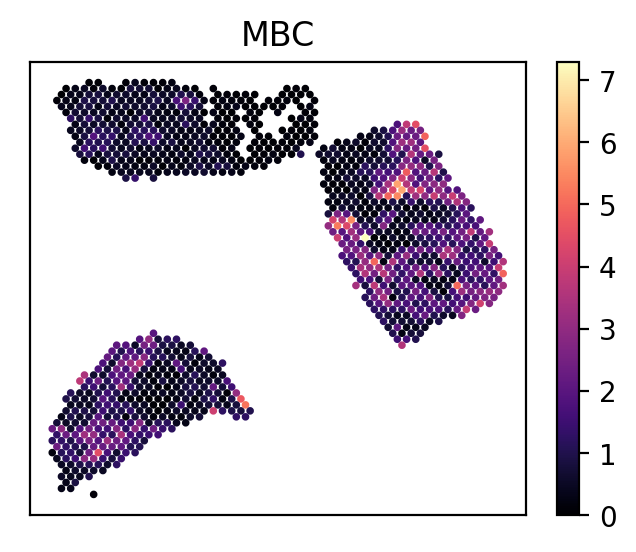

In [108]:
idx=11
plot_utils.pl_spatial_gsva(adata_sample,map_info,gene_sig_exp_m,idx,s=3,plt_title=gsva_score.columns[idx])

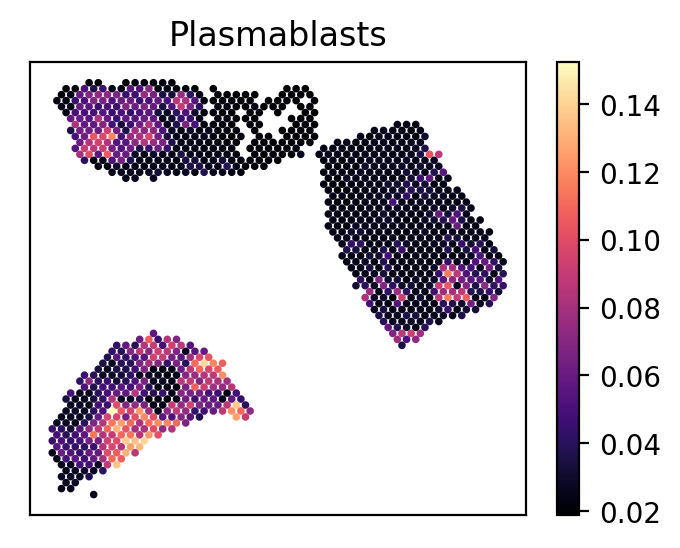

In [130]:
idx=25
plot_utils.pl_spatial_gsva(adata_sample,map_info,qc_p_df,idx,s=3,plt_title=gsva_score.columns[idx])